In [536]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from skimage.measure import block_reduce
from skimage.transform import resize

# Amazon bounds
lat_min, lat_max = -15, 5
lon_min, lon_max = -75, -50

sif_amazon = []
time_list = []

data_dir = data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"

# Get all available files
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
print("Files found:", files)
for file in files:
    match = re.search(r"month-(\d{6})", file)
    if match:
        date_str = match.group(1)  # Extract YYYYMM
        year = int(date_str[:4])  
        month = int(date_str[4:6])  

        file_path = os.path.join(data_dir, file)
        
        try:
            ds = xr.open_dataset(file_path)
        except Exception as e:
            print(f"Error opening {file_path}: {e}")
            continue
        ds_amazon = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["solar_induced_fluorescence"].values)  # Shape: [time, lat, lon]
        time_list.append(f"{year}-{month:02d}")
        # Ensure data was loaded
if not sif_amazon or not time_list:
    raise ValueError("No valid data found. Check the input files and filtering logic.")
# Convert to numpy array
sif_amazon = np.stack(sif_amazon, axis=0).squeeze()  # Shape: [N_months, lat, lon]

# Group into years
years = sorted(set(int(t.split("-")[0]) for t in time_list))

num_years = len(years)

# Initialize an empty array with NaNs
sif_monthly = np.full((num_years, 12, *sif_amazon.shape[1:]), np.nan)
# Fill in available months
for i, month_data in enumerate(sif_amazon):
    year_idx = i // 12  # Get year index
    month_idx = i % 12  # Get month index
    sif_monthly[year_idx, month_idx] = month_data  # Assign data

print("Fixed sif_monthly shape:", sif_monthly.shape)
# solar_induced_fluorescence_uncertainty         (time, latitude, longitude) float32 537MB .
#solar_induced_fluorescence_uncertainty_weight  (time, latitude, longitude) float32 537MB ...

# # Calculate the monthly mean over all pixels for February 2023
# year_idx = years.index(2024)  # Find the index for the year 2023
# month_idx = 1  # February (0-based index)

# february_2024_mean = np.nanmean(sif_monthly[year_idx, month_idx])
# print(f"Monthly mean SIF for February 2023: {february_2024_mean}")

# # Compute mean SIF in January 2024 over area: lat -25 to 10, lon -65 to -60
# year_idx_2024 = years.index(2024)
# month_idx_jan = 0  # January

# # Get latitude and longitude arrays for the grid
# lat_grid = np.linspace(lat_min, lat_max, sif_monthly.shape[2])
# lon_grid = np.linspace(lon_min, lon_max, sif_monthly.shape[3])

# # Find indices for the specified lat/lon bounds
# lat_mask = (lat_grid >= -25) & (lat_grid <= 10)
# lon_mask = (lon_grid >= -65) & (lon_grid <= -60)

# # Extract the region and compute the mean
# sif_jan_2024_region = sif_monthly[year_idx_2024, month_idx_jan][np.ix_(lat_mask, lon_mask)]
# mean_sif_jan_2024_region = np.nanmean(sif_jan_2024_region)
# median_sif_jan_2024_region = np.nanmedian(sif_jan_2024_region)
# print("Mean SIF in January 2024 over lat -25 to 10, lon -65 to -60:", mean_sif_jan_2024_region)
# print("median:", median_sif_jan_2024_region)

Files found: ['s5p-l3grd-sif-001-month-20190101-20240325.nc', 's5p-l3grd-sif-001-month-20190201-20240325.nc', 's5p-l3grd-sif-001-month-20190301-20240325.nc', 's5p-l3grd-sif-001-month-20190401-20240325.nc', 's5p-l3grd-sif-001-month-20190501-20240325.nc', 's5p-l3grd-sif-001-month-20190601-20240325.nc', 's5p-l3grd-sif-001-month-20190701-20240325.nc', 's5p-l3grd-sif-001-month-20190801-20240325.nc', 's5p-l3grd-sif-001-month-20190901-20240325.nc', 's5p-l3grd-sif-001-month-20191001-20240325.nc', 's5p-l3grd-sif-001-month-20191101-20240325.nc', 's5p-l3grd-sif-001-month-20191201-20240325.nc', 's5p-l3grd-sif-001-month-20200101-20240325.nc', 's5p-l3grd-sif-001-month-20200201-20240325.nc', 's5p-l3grd-sif-001-month-20200301-20240325.nc', 's5p-l3grd-sif-001-month-20200401-20240325.nc', 's5p-l3grd-sif-001-month-20200501-20240325.nc', 's5p-l3grd-sif-001-month-20200601-20240325.nc', 's5p-l3grd-sif-001-month-20200701-20240325.nc', 's5p-l3grd-sif-001-month-20200801-20240325.nc', 's5p-l3grd-sif-001-month-2

In [580]:
has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)
mean_sif_monthly = np.nanmean(sif_monthly)
sif_monthly = np.nan_to_num(sif_monthly, nan=mean_sif_monthly)
sif_monthly_climatology = sif_monthly[:4]  # shape: (4, 12, lat, lon)
print("sif_monthly_climatology shape:", sif_monthly_climatology.shape)
climatology = np.nanmean(sif_monthly_climatology, axis=0)


# Compute monthly means: Average over spatial dimensions
monthly_means = np.nanmean(climatology, axis=(1, 2))  # Shape: (12,)

# Compute overall mean SIF across all months
overall_mean_sif = np.nanmean(monthly_means)

# Create a climatology table
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': np.round(monthly_means, 3)  # Rounded to 3 decimals
})

# Convert the climatology table to a LaTeX table
latex_table = climatology_table.to_latex(index=False, caption="Monthly Climatology Summary", label="tab:climatology", float_format="%.3f")
#print(latex_table)

print("Monthly Climatology Summary:")
print(climatology_table)

print("\nOverall Mean SIF:", round(overall_mean_sif, 3))



has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)


Does sif_monthly contain NaNs? True
sif_monthly_climatology shape: (4, 12, 911, 1137)
Monthly Climatology Summary:
        Month  Avg SIF
0     January    1.399
1    February    1.303
2       March    1.303
3       April    1.226
4         May    1.170
5        June    1.116
6        July    1.076
7      August    1.054
8   September    1.090
9     October    1.303
10   November    1.439
11   December    1.460

Overall Mean SIF: 1.245
Does sif_monthly contain NaNs? False


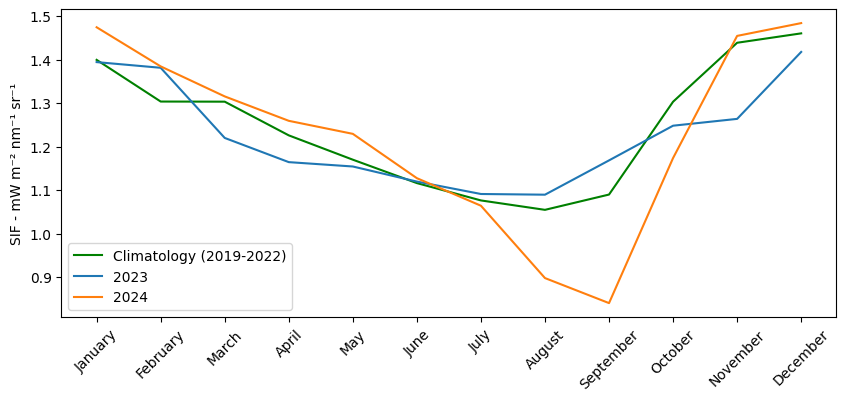

In [496]:
plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, color='green', label ='Climatology (2019-2022)')
plt.plot(months, sif_monthly[4,:,:,:].mean(axis=(1, 2)), label='2023')
plt.plot(months, sif_monthly[5,:,:,:].mean(axis=(1, 2)), label='2024') 
plt.ylabel("SIF - mW m⁻² nm⁻¹ sr⁻¹")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("pic/sif_climatology.png")
plt.show()

#there seems to be an anomaly in 2024 in august and septemver and then in 2023 it deviates in november and december maybe march april.

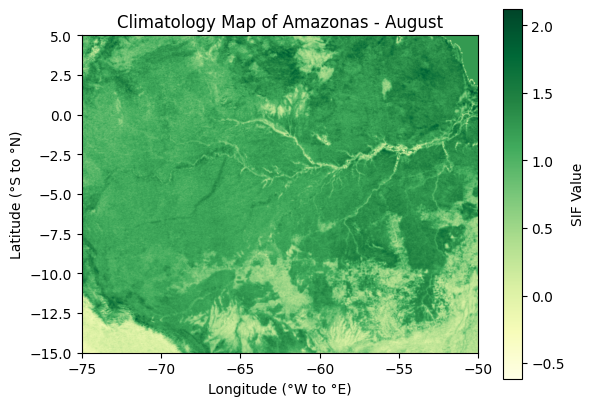

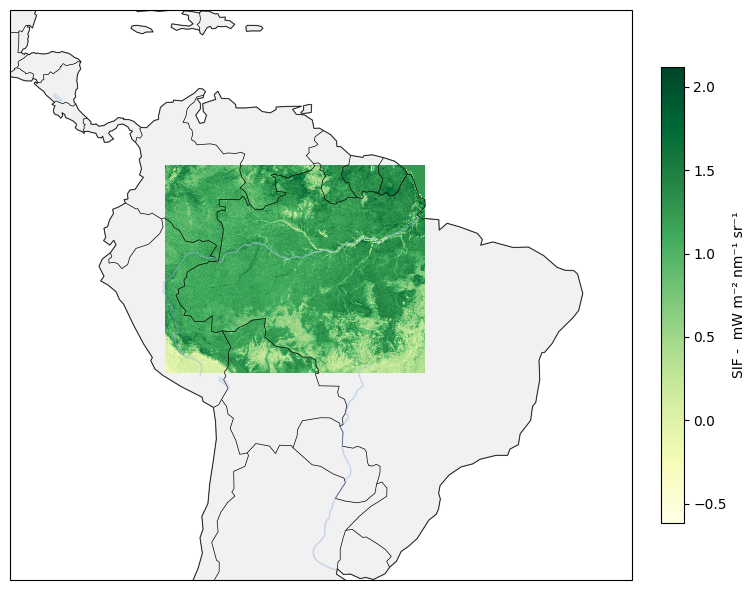

In [ ]:
# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(climatology[month_idx], cmap='YlGn', origin = 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='SIF Value')
plt.xlabel("Longitude (°W to °E)")
plt.ylabel("Latitude (°S to °N)")
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

# Choose a month (0 = January, ..., 11 = December)
month_idx = 7  # August

# Get the SIF data slice (2D array)
sif_data = climatology[month_idx]

# Generate coordinate grids
lat = np.linspace(lat_min, lat_max, sif_data.shape[0])
lon = np.linspace(lon_min, lon_max, sif_data.shape[1])
lon2d, lat2d = np.meshgrid(lon, lat)

# Create a Cartopy map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -30, -35, 20], crs=ccrs.PlateCarree())  # Wider region for context

# Add features (land, borders, etc.)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.3)

# Plot the SIF data
im = ax.pcolormesh(lon2d, lat2d, sif_data, cmap="YlGn", shading="auto", transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03, shrink=0.8)
cbar.set_label("SIF -  mW m⁻² nm⁻¹ sr⁻¹")

# Add labels
#plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.tight_layout()
plt.show()



sif_strided shape: (5, 100, 12, 91, 113)
sif_08_2024_downsampled shape: (91, 113)
sif_patches_combined shape: (500, 12, 91, 113)


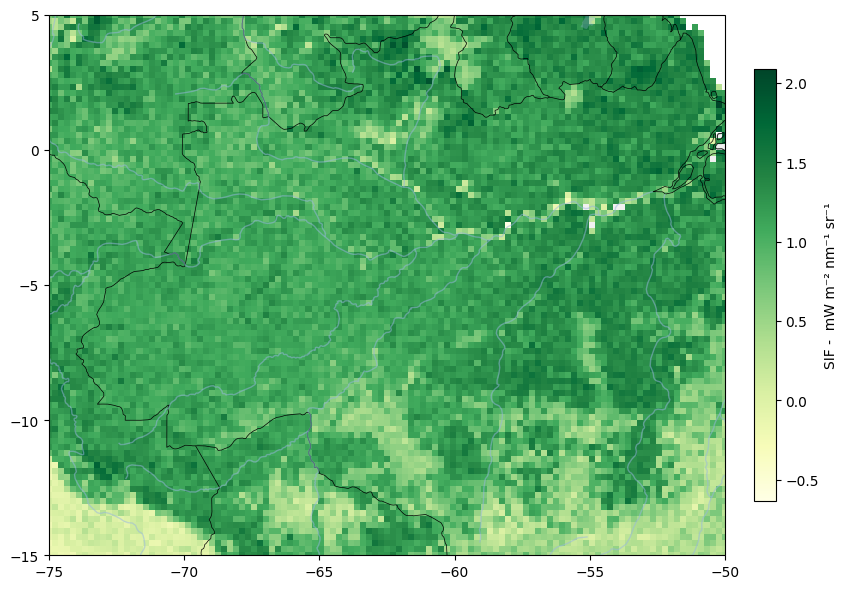

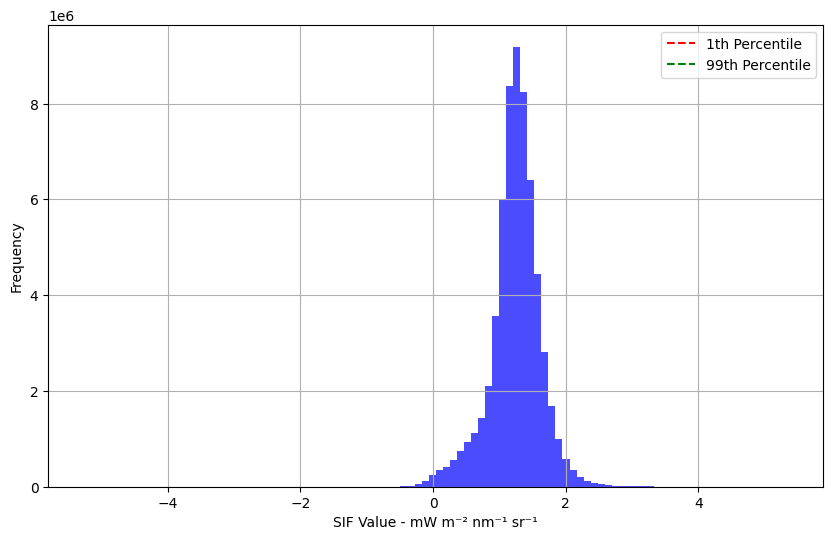

In [552]:

def create_strided_downsamples(data, modulo):
    years, months, h, w = data.shape

    # Crop to make h and w divisible by modulo
    new_h = (h // modulo) * modulo
    new_w = (w // modulo) * modulo
    cropped = data[..., :new_h, :new_w]

    versions = []
    for row_mod in range(modulo):
        for col_mod in range(modulo):
            version = cropped[..., row_mod::modulo, col_mod::modulo]
            versions.append(version)

    return np.stack(versions, axis=1)
sif_strided = create_strided_downsamples(sif_monthly[0:5],10) 
print("sif_strided shape:", sif_strided.shape)  # Should be (6, 4, 12, h', w')
sif_08_2024_downsampled = sif_strided[0,2, 7, :, :]  # Get the downsampled data for August 2019
print("sif_08_2024_downsampled shape:", sif_08_2024_downsampled.shape)  # Should be (h', w')
sif_patches = sif_strided.reshape(-1, 12, sif_strided.shape[-2], sif_strided.shape[-1])
print("sif_patches_combined shape:", sif_patches.shape)


# Plot the selected SIF patch on a Cartopy map for spatial context
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.3)

xticks = np.linspace(lon_min, lon_max, 6)
yticks = np.linspace(lat_min, lat_max, 5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.tick_params(labelsize=10)


im = ax.pcolormesh(
    np.linspace(lon_min, lon_max, sif_patches.shape[-1]),
    np.linspace(lat_min, lat_max, sif_patches.shape[-2]),
    sif_08_2024_downsampled,
    cmap="YlGn",
    shading="auto",
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03, shrink=0.8)
cbar.set_label("SIF -  mW m⁻² nm⁻¹ sr⁻¹")
#plt.title(f"Map SIF of Amazonas Downsized - {months[month_idx]} 2019")
plt.tight_layout()
plt.show()

# Flatten the sif_patches_combined array to a 1D array for distribution plotting
sif_patches_flat = sif_patches.flatten()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(sif_patches_flat, bins=100, color='blue', alpha=0.7)

# Calculate the 5th and 95th percentiles
percentile_5 = np.percentile(sif_patches_flat, 1)
percentile_95 = np.percentile(sif_patches_flat, 99)

# Add vertical lines for the 5th and 95th percentiles
plt.axvline(percentile_5, color='red', linestyle='--', label='1th Percentile')
plt.axvline(percentile_95, color='green', linestyle='--', label='99th Percentile')

# Add legend to the plot
plt.legend()
#plt.title("Distribution of SIF Downsized Data")
plt.xlabel("SIF Value - mW m⁻² nm⁻¹ sr⁻¹")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [499]:
import tensorflow as tf
from tensorflow.keras import regularizers

class Conv3DAutoencoder(tf.keras.Model):
    def __init__(self, input_shape):
        super(Conv3DAutoencoder, self).__init__()

        # --- Encoder ---
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),
            tf.keras.layers.Conv3D(16, (3, 3, 3), padding='same',
                                   activation=tf.keras.layers.LeakyReLU()),
            tf.keras.layers.MaxPooling3D((2, 2, 2), padding='same'),
            tf.keras.layers.Conv3D(8, (3, 3, 3), padding='same',
                                   activation=tf.keras.layers.ReLU()),
            tf.keras.layers.MaxPooling3D((2, 2, 2), padding='same'),
        ])

        # --- Decoder ---
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.UpSampling3D((2, 2, 2)),
            tf.keras.layers.Conv3D(8, (3, 3, 3), padding='same',
                                   activation=tf.keras.layers.LeakyReLU()),
            tf.keras.layers.UpSampling3D((2, 2, 2)),
            tf.keras.layers.Conv3D(16, (3, 3, 3), padding='same',
                                   activation=tf.keras.layers.LeakyReLU()),
            
            tf.keras.layers.Cropping3D(((0, 0), (0, 1), (0, 3))),  
            tf.keras.layers.Conv3D(1, (3, 3, 3), padding='same',
                                activation=tf.keras.layers.ReLU())
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
    
# Prepare input
input_sequences = sif_patches[..., tf.newaxis]  # shape: (n, 12, h, w, 1)

# Define model
input_shape = input_sequences.shape[1:]  # (12, h, w, 1)
autoencoder = Conv3DAutoencoder(input_shape)

dummy_input = tf.zeros((1,) + input_shape)
_ = autoencoder(dummy_input)

autoencoder.encoder.summary()
autoencoder.decoder.summary()

# Compile
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
# Train
autoencoder.fit(input_sequences, input_sequences,
                epochs=20,
                batch_size=30,
                validation_split=0.2,
                shuffle=True)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_197 (Conv3D)             │ (None, 12, 91, 113,    │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_74 (MaxPooling3D) │ (None, 6, 46, 57, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_198 (Conv3D)             │ (None, 6, 46, 57, 8)   │         3,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_75 (MaxPooling3D) │ (None, 3, 23, 29, 8)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,912 (15.28 KB)

 Trainable params: 3,912 (15.28 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling3d_72 (UpSampling3D) │ (1, 6, 46, 58, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_199 (Conv3D)             │ (1, 6, 46, 58, 8)      │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_73 (UpSampling3D) │ (1, 12, 92, 116, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_200 (Conv3D)             │ (1, 12, 92, 116, 16)   │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping3d_37 (Cropping3D)      │ (1, 12, 91, 113, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_201 (Conv3D)             │ (1, 12, 91, 113, 1)    │           433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,641 (22.04 KB)

 Trainable params: 5,641 (22.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "conv3d_autoencoder_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_44 (Sequential)      │ (None, 3, 23, 29, 8)   │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_45 (Sequential)      │ (1, 12, 91, 113, 1)    │         5,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 1.0009 - val_loss: 0.2512
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 0.2321 - val_loss: 0.1497
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 0.1401 - val_loss: 0.0853
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 0.0891 - val_loss: 0.0811
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - loss: 0.0790 - val_loss: 0.0761
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 0.0735 - val_loss: 0.0714
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - loss: 0.0688 - val_loss: 0.0679
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - loss: 0.0652 - val_loss: 0.0646
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - loss: 0.0623 - val_loss: 0.0626
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 0.0599 - val_loss: 0.0612
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2773s 213s/step - loss: 0.0584 - val_loss: 0.0600
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.0572 - va

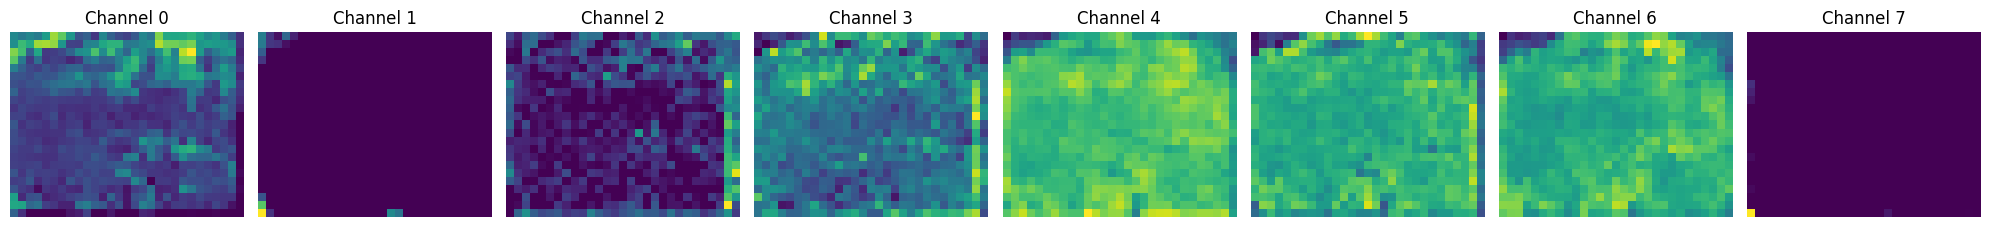

In [ ]:
# Get the encoded output for some input
encoded_outputs = autoencoder.encoder(input_sequences)  # shape: (n_samples, d1, d2, d3, 8)
sample_idx = 0
depth = encoded_outputs.shape[1] // 2  # middle slice

# Get all 8 channel maps for that slice
fig, axs = plt.subplots(1, 8, figsize=(20, 4))
for i in range(8):
    axs[i].imshow(encoded_outputs[sample_idx, depth, :, :, i], cmap='viridis')
    axs[i].set_title(f"Channel {i}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(12, 92, 115)


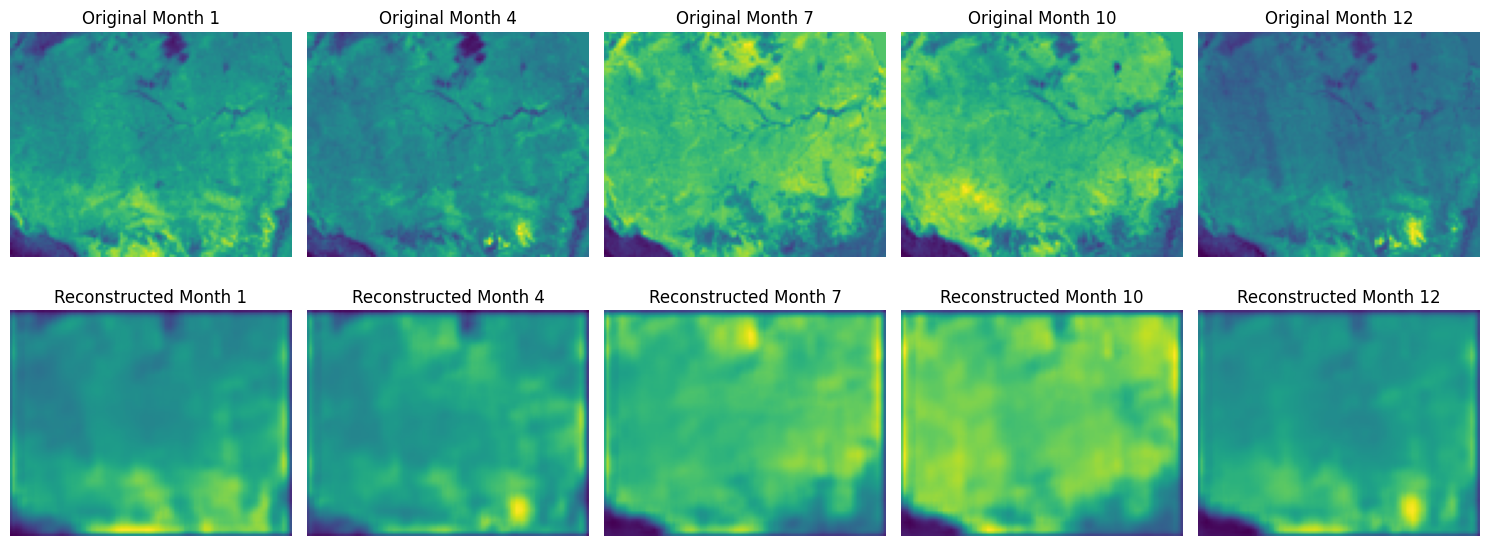

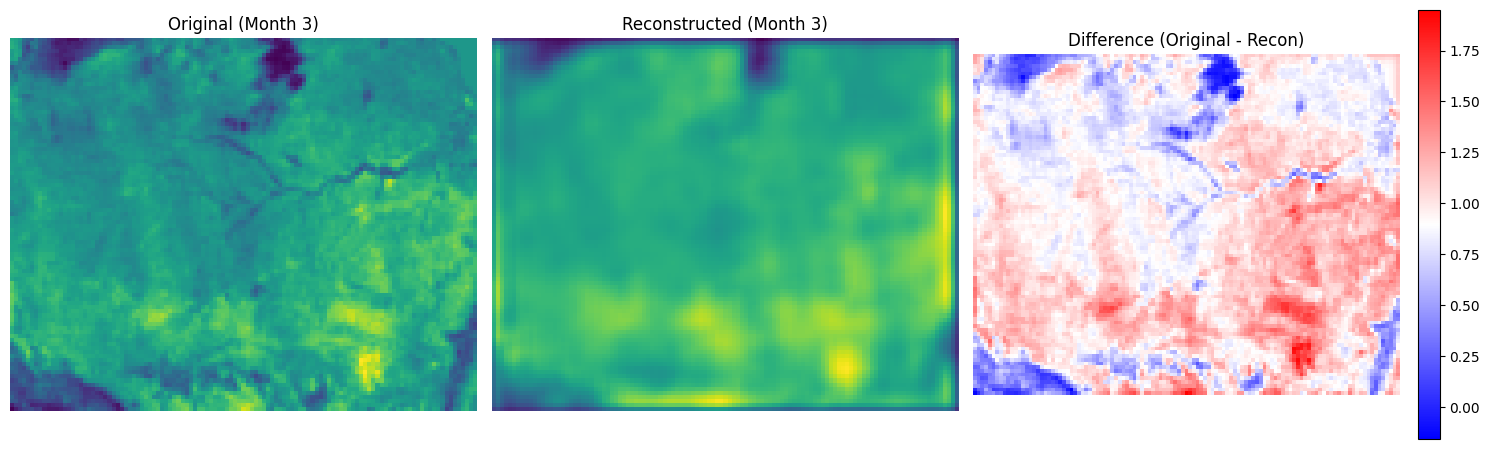

In [581]:
# Resize each year's data to (12, 100, 100)
sif_monthly_resized = np.empty((sif_monthly.shape[0], sif_monthly.shape[1], 92, 115))
for year_idx in range(sif_monthly.shape[0]):
    for month_idx in range(sif_monthly.shape[1]):
        sif_monthly_resized[year_idx, month_idx] = resize(
            sif_monthly[year_idx, month_idx],
            (92, 115),
            anti_aliasing=True
        )


original = sif_monthly_resized[..., np.newaxis]  # shape: (6, 12, 100,100 , 1) # Use the first 12 months for reconstruction
reconstructed = autoencoder.predict(original[1, :, :, :, :])
reconstructed = reconstructed[..., 0, 0] 
original = original[... , 0]  # Use the first year for comparison
print(reconstructed.shape)  

# Plot several time steps (e.g., 0, 3, 6, 9, 11)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

time_steps = [0, 3, 6, 9, 11]
for i, t in enumerate(time_steps):
    axes[0, i].imshow(original[0,t], cmap='viridis', origin='lower')
    axes[0, i].set_title(f'Original Month {t+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed[t, ], cmap='viridis', origin='lower')
    axes[1, i].set_title(f'Reconstructed Month {t+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()



# Plot the original, reconstructed, and difference for that month
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(original[0,2], cmap='viridis', origin='lower')
axs[0].set_title(f'Original (Month {2+1})')
axs[0].axis('off')

axs[1].imshow(reconstructed[2], cmap='viridis', origin='lower')
axs[1].set_title(f'Reconstructed (Month {2+1})')
axs[1].axis('off')

diff = original[0,2] - reconstructed[2]
im = axs[2].imshow(diff, cmap='bwr', origin='lower')
axs[2].set_title('Difference (Original - Recon)')
axs[2].axis('off')
plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [502]:
from keras import regularizers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D
from keras.models import Model
import numpy as np

# Clip outliers
#sif_monthly_clipped = np.clip(sif_patches, np.percentile(sif_patches, 1), np.percentile(sif_patches, 99))
input_sequences = sif_patches[..., np.newaxis]  # Add channel dimension

# Input shape: (12, lat, lon, 1)
input_seq = Input(shape=(12, sif_patches.shape[2], sif_patches.shape[3], 1))

# --- Encoder ---
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_seq)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same',
                       activity_regularizer=regularizers.l1(1e-5))(x)

# --- Decoder (mirror of encoder) ---
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
x = Cropping3D(((0, 0), (0,  x.shape[2] - input_seq.shape[2]), (0, x.shape[3] - input_seq.shape[3])))(x)
decoded = Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)

# --- Autoencoder Model ---
autoencoder2 = Model(input_seq, decoded)
autoencoder2.compile(optimizer='adam', loss='mse')
autoencoder2.summary()



Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 12, 91, 113, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_202 (Conv3D)             │ (None, 12, 91, 113,    │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_76 (MaxPooling3D) │ (None, 6, 46, 57, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_203 (Conv3D)             │ (None, 6, 46, 57, 8)   │         3,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_77 (MaxPooling3D) │ (None, 3, 23, 29, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_204 (Conv3D)             │ (None, 3, 23, 29, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_74 (UpSampling3D) │ (None, 6, 46, 58, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_205 (Conv3D)             │ (None, 6, 46, 58, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_75 (UpSampling3D) │ (None, 12, 92, 116,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping3d_38 (Cropping3D)      │ (None, 12, 91, 113,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_206 (Conv3D)             │ (None, 12, 91, 113, 1) │           433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

In [521]:
import numpy as np
np.random.seed(42)
autoencoder2.fit(input_sequences, input_sequences, 
                epochs=50,
                batch_size=30,
                validation_split=0.2,
                shuffle=True)

                


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.1167 - val_loss: 0.1112
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.1059 - val_loss: 0.0943
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0951 - val_loss: 0.0932
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0934 - val_loss: 0.0932
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0917 - val_loss: 0.0917
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0895 - val_loss: 0.0892
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0875 - val_loss: 0.0890
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0863 - val_loss: 0.0870
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0844 - val_loss: 0.0880
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0842 - val_loss: 0.0865
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0834 - val_loss: 0.0851
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0813 - val_lo

Model saved to autoencoder_sif_model.keras
Model file 'autoencoder_sif_model.keras' exists and is not empty.


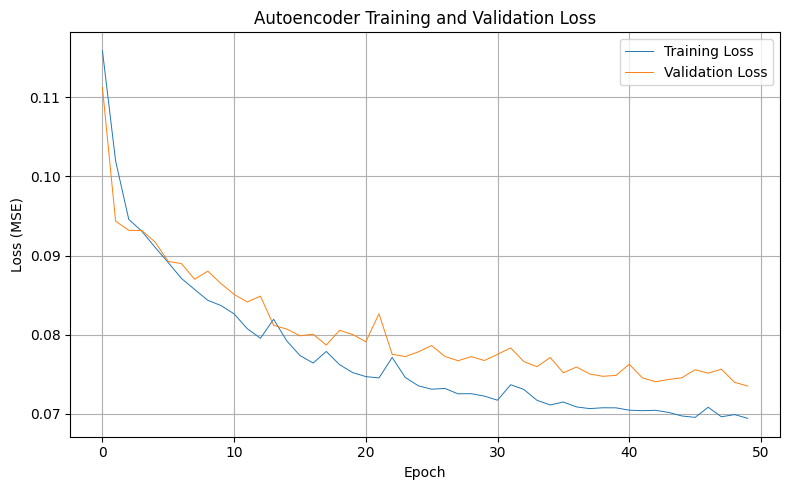

In [525]:
autoencoder2.save("autoencoder_sif_model.keras")
print("Model saved to autoencoder_sif_model.keras")

# Check if the file exists and its size is greater than zero
model_path = "autoencoder_sif_model.keras"
if os.path.isfile(model_path) and os.path.getsize(model_path) > 0:
    print(f"Model file '{model_path}' exists and is not empty.")
else:
    print(f"Model file '{model_path}' is missing or empty.")

if 'autoencoder' in locals() and hasattr(autoencoder2, 'history') and autoencoder2.history is not None:
    history = autoencoder2.history
else:
    print("Training history not found. Please ensure you have the training history object.")
    history = None

if history is not None:
    if hasattr(history, 'history'):
        hist_dict = history.history
    else:
        hist_dict = history

    plt.figure(figsize=(8, 5))
    plt.plot(hist_dict['loss'], linewidth=0.7,label='Training Loss')
    if 'val_loss' in hist_dict:
        plt.plot(hist_dict['val_loss'], linewidth=0.7, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Autoencoder Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step


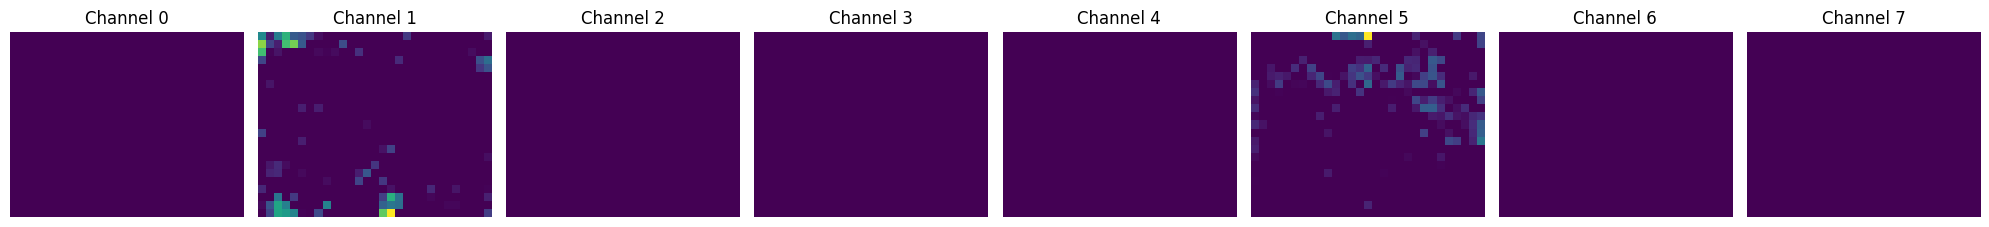

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Reconstructed shape: (6, 12, 91, 113, 1)
Reconstructed sample shape: (12, 91, 113, 1)


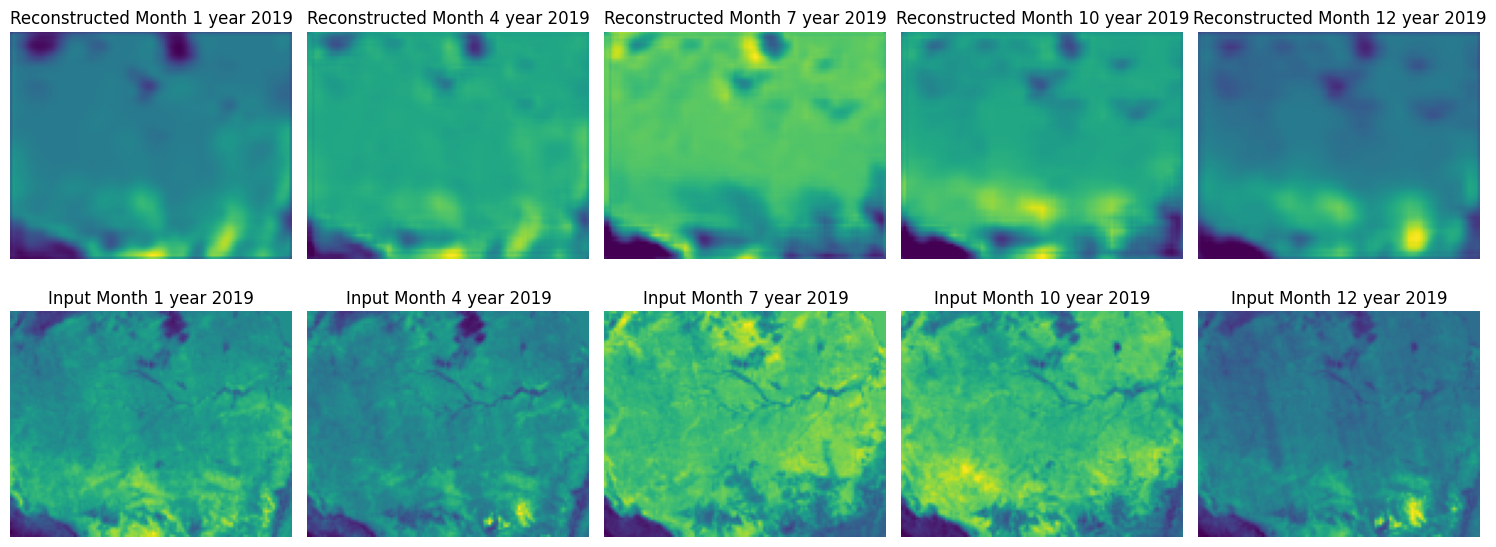

Reconstructed sample shape: (12, 91, 113, 1)


In [582]:
from keras.models import Model
from sklearn.decomposition import PCA

# Visualize the latent space of the encoder from autoencoder2

# Get the encoder part (up to 'encoded' layer)

# Find the encoded layer by name or index (here, 'encoded' is the variable in the code)
encoder_model = Model(inputs=autoencoder2.input, outputs=encoded)

# Pass the input sequences through the encoder to get latent representations
latent_representations = encoder_model.predict(input_sequences)  # shape: (n_samples, d1, d2, d3, 8)

# Visualize all channels of the latent representation for a specific input (e.g., first validation sample)
sample_idx = 0  # Change this to visualize a different sample
latent_sample = latent_representations[sample_idx]  # shape: (d1, d2, d3, 8)

num_channels = latent_sample.shape[-1]
fig, axs = plt.subplots(1, num_channels, figsize=(20, 3))
for i in range(num_channels):
    axs[i].imshow(latent_sample[0,... , i], cmap='viridis')
    axs[i].set_title(f'Channel {i}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

original = sif_monthly_resized[..., np.newaxis]  # shape: (6, 12, 100,100 , 1) # Use the first 12 months for reconstruction
reconstruct = autoencoder2.predict(original[:, :, :, :])
print("Reconstructed shape:", reconstruct.shape)  # Should be (6, 12, 100, 100, 1)
# Visualize the shape of a reconstructed validation sample
sample_idx = 0  # Change to view a different sample
recon_sample = reconstruct[sample_idx]  # shape: (12, 91, 113, 1)
print("Reconstructed sample shape:", recon_sample.shape)
# Plot several time steps (e.g., months 0, 3, 6, 9, 11)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
time_steps = [0, 3, 6, 9, 11]
for i, t in enumerate(time_steps):
    axes[0, i].imshow(recon_sample[t, :, :], cmap='viridis', origin='lower')
    axes[0, i].set_title(f'Reconstructed Month {t+1} year {sample_idx+2019}')
    axes[0, i].axis('off')

    # Optionally, plot the corresponding latent channel (e.g., channel 0)
    axes[1, i].imshow(original[0, t, :, :], cmap='viridis', origin='lower')
    axes[1, i].set_title(f'Input Month {t+1} year {sample_idx+2019}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("Reconstructed sample shape:", recon_sample.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Reconstructed shape: (6, 12, 91, 113, 1)
Original shape: (6, 12, 91, 113) Reconstructed shape: (6, 12, 91, 113)
NaNs in original: 0
NaNs in reconstructed: 0
Reconstruction error shape: (12, 91, 113)


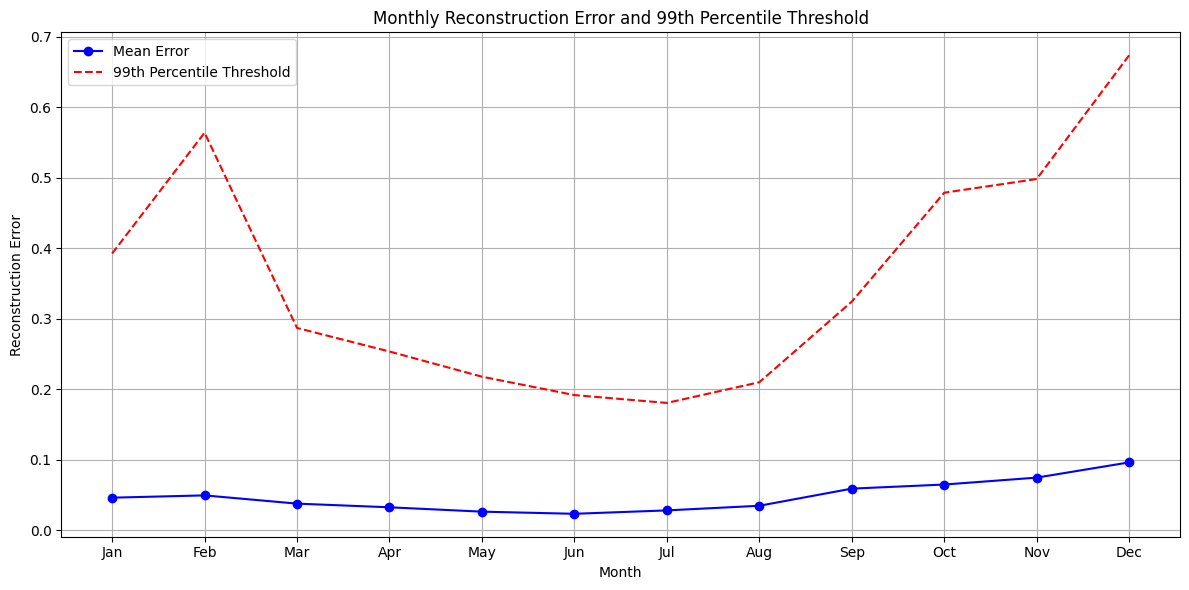

(1, 12, 91, 113)


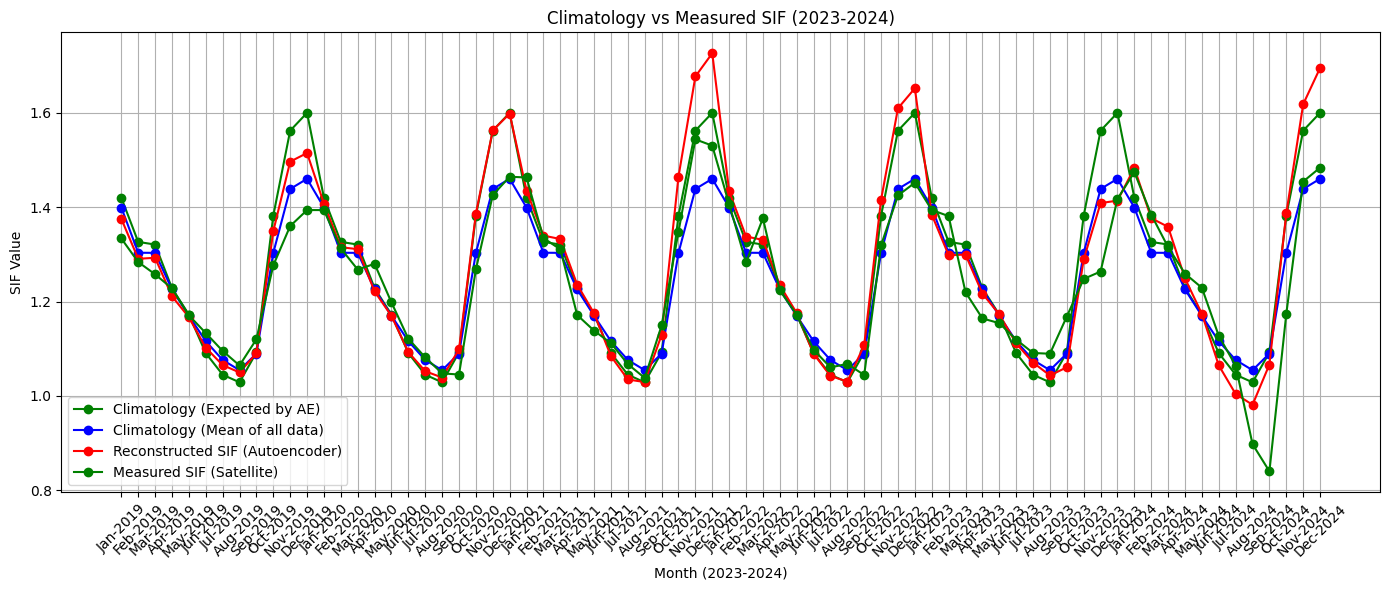

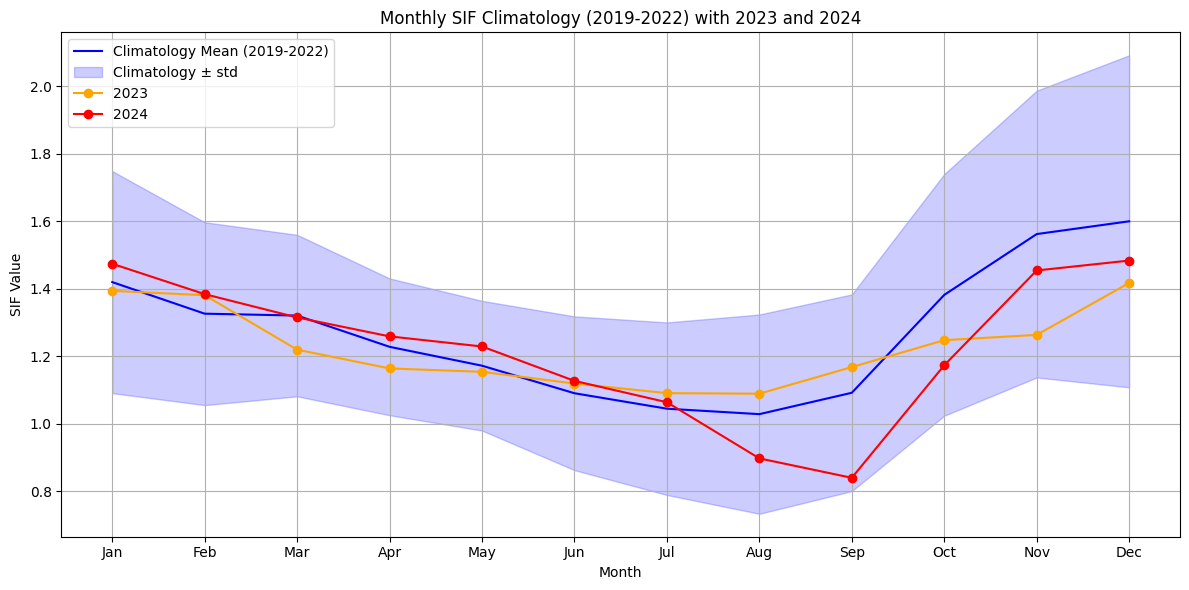

Least reconstruction error index: (np.int64(4), np.int64(5), np.int64(17), np.int64(94))
Least reconstruction error value: 4.870339660836509e-13


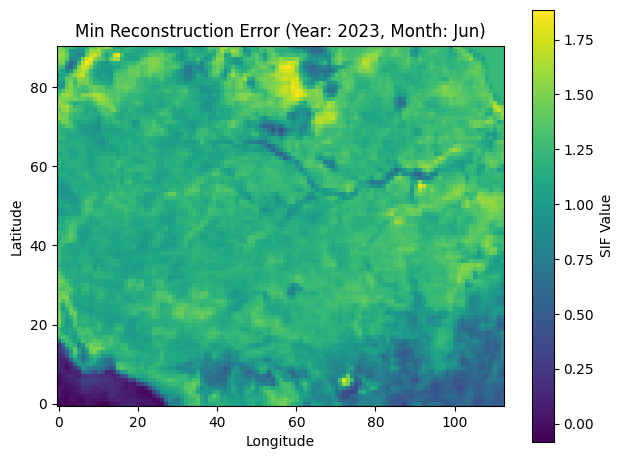

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reconstruction error shape on downsized: 0.04804933530990389


In [586]:
# Resize each year's data to (12, 100, 100)

# The reconstruction_error_pixel contains NaN values because the original or reconstructed arrays likely contain NaNs.
# This can happen if the input data (sif_monthly or sif_monthly_resized) has missing values (NaNs), and these propagate through the model and error calculation.
# When you compute (original - reconstructed) ** 2, any NaN in either array will result in NaN in the output.
# np.nanmean ignores NaNs in the mean, but if all values along the axis are NaN, the result will be NaN.
# To avoid this, you can check your input data for NaNs and consider masking or imputing them before passing to the model.


sif_monthly_resized = np.empty((sif_monthly.shape[0], sif_monthly.shape[1], 91, 113))
for year_idx in range(sif_monthly.shape[0]):
    for month_idx in range(sif_monthly.shape[1]):
        sif_monthly_resized[year_idx, month_idx] = resize(
            sif_monthly[year_idx, month_idx],
            (91, 113),
            anti_aliasing=True
        )


original = sif_monthly_resized[..., np.newaxis]  # shape: (6, 12, 100,100 , 1) # Use the first 12 months for reconstruction

reconstructed = autoencoder2.predict(original)
print("Reconstructed shape:", reconstructed.shape)  # Should be (6, 12, 100, 100, 1)
reconstructed = reconstructed[..., 0]  # Remove the last two dimensions
original = original[... , 0]  # Use the first year for comparison
print("Original shape:", original.shape, "Reconstructed shape:", reconstructed.shape)

# Example: Check for NaNs in your data
print("NaNs in original:", np.isnan(original).sum())
print("NaNs in reconstructed:", np.isnan(reconstructed).sum())


reconstruction_error_pixel = np.nanmean((original - reconstructed) ** 2, axis = 0)
print("Reconstruction error shape:", reconstruction_error_pixel.shape) 

#this threshold is for general areas, not pixel per pixel 
thresholds_per_month = np.percentile(reconstruction_error_pixel, 99, axis=(1, 2))  # shape: (12,)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


# Compute min, max, and mean errors per year and month but over all pixels

min_errors = np.min(reconstruction_error_pixel, axis=(1, 2))  # shape: (6, 12)
max_errors = np.max(reconstruction_error_pixel, axis=(1, 2))  # shape: (6, 12)
mean_errors = np.mean(reconstruction_error_pixel, axis=(1, 2))  # shape: (6, 12)
#print("Min overall reconstruction error per month:", min_errors, "Max overall reconstruction error per month:", max_errors)


# Plot
plt.figure(figsize=(12, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(range(12), mean_errors, 'b-', label='Mean Error', marker='o')
plt.plot(range(12), thresholds_per_month, 'r--', label='99th Percentile Threshold')

plt.xticks(range(12), months)
plt.xlabel('Month')
plt.ylabel('Reconstruction Error')
plt.title('Monthly Reconstruction Error and 99th Percentile Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


anomalies_month = reconstruction_error_pixel > thresholds_per_month.reshape(1, 12, 1, 1)  #anomalies per month not subject to pixel
print(anomalies_month.shape)
# Compute the usual climatology of SIF per month

# Extend the months list to include 24 months for 2023-2024
extended_months = [f"{month}-{year}" for year in [2019, 2020, 2021, 2022, 2023, 2024] for month in months]

# Concatenate the climatology and measured SIF for 2023-2024
climatology_24_months = np.mean(climatology, axis = (1,2)) # Shape: (24,)
climatology_24_months = np.tile(climatology_24_months, 6)  # Repeat the 12-month climatology 6 times
climatology_AE_mean = np.mean(reconstructed, axis = (0,2,3))
climatology_AE_std = np.std(reconstructed, axis = (0,2,3))
climatology_AE = np.tile(climatology_AE_mean, 6)
AE_reconstruction = np.mean(reconstructed, axis = (2,3)).flatten() 
sif_measured_24_months = np.mean(sif_monthly, axis = (2,3)).flatten() 



plt.figure(figsize=(14, 6))
plt.plot(extended_months, climatology_AE, label="Climatology (Expected by AE)", color="green", marker="o")
plt.plot(extended_months, climatology_24_months, label="Climatology (Mean of all data)", color="blue", marker="o")
plt.plot(extended_months, AE_reconstruction, label="Reconstructed SIF (Autoencoder)", color="red", marker="o")
plt.plot(extended_months, sif_measured_24_months, label="Measured SIF (Satellite)", color="green", marker="o")

plt.xlabel("Month (2023-2024)")
plt.ylabel("SIF Value")
plt.title("Climatology vs Measured SIF (2023-2024)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, climatology_AE_mean, label='Climatology Mean (2019-2022)', color='blue')
plt.fill_between(months, climatology_AE_mean - climatology_AE_std, climatology_AE_mean + climatology_AE_std, color='blue', alpha=0.2, label='Climatology ± std')

plt.plot(months, np.nanmean(sif_monthly_resized[4], axis=(1, 2)), label='2023', color='orange', marker='o')
plt.plot(months, np.nanmean(sif_monthly_resized[5], axis=(1, 2)), label='2024', color='red', marker='o')

plt.xlabel('Month')
plt.ylabel('SIF Value')
plt.title('Monthly SIF Climatology (2019-2022) with 2023 and 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Find the input with the least reconstruction error
reconstruction_error = (original - reconstructed) ** 2
least_error_idx = np.unravel_index(np.argmin(reconstruction_error), reconstruction_error.shape)
least_error_input = original[least_error_idx[0], least_error_idx[1]]

print(f"Least reconstruction error index: {least_error_idx}")
print(f"Least reconstruction error value: {reconstruction_error[least_error_idx]}")

# Visualize the input with the least reconstruction error
plt.imshow(least_error_input.squeeze(), cmap='viridis', origin='lower')
plt.colorbar(label='SIF Value')
plt.title(f"Min Reconstruction Error (Year: {years[least_error_idx[0]]}, Month: {months[least_error_idx[1]]})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# Compute reconstruction error on sif_monthly_downsized
# Assume sif_monthly_downsized shape: (years, months, lat, lon)
sif_monthly_downsized_expanded = sif_monthly_resized[..., np.newaxis]  # Add channel dimension if needed

# Predict using autoencoder2
reconstructed_downsized = np.zeros_like(sif_monthly_downsized_expanded)
for i in range(sif_monthly_downsized_expanded.shape[0]):
    pred = autoencoder2.predict(sif_monthly_downsized_expanded[None, i, ...])
    reconstructed_downsized[i] = pred

# Remove channel dimension for error calculation
original_downsized = sif_monthly_downsized_expanded[..., 0]
reconstruction_error_downsized = (original_downsized - reconstructed_downsized[..., 0]) ** 2

print("Reconstruction error shape on downsized:", np.nanmean(reconstruction_error_downsized))


Reconstruction error shape: (6, 12, 91, 113)


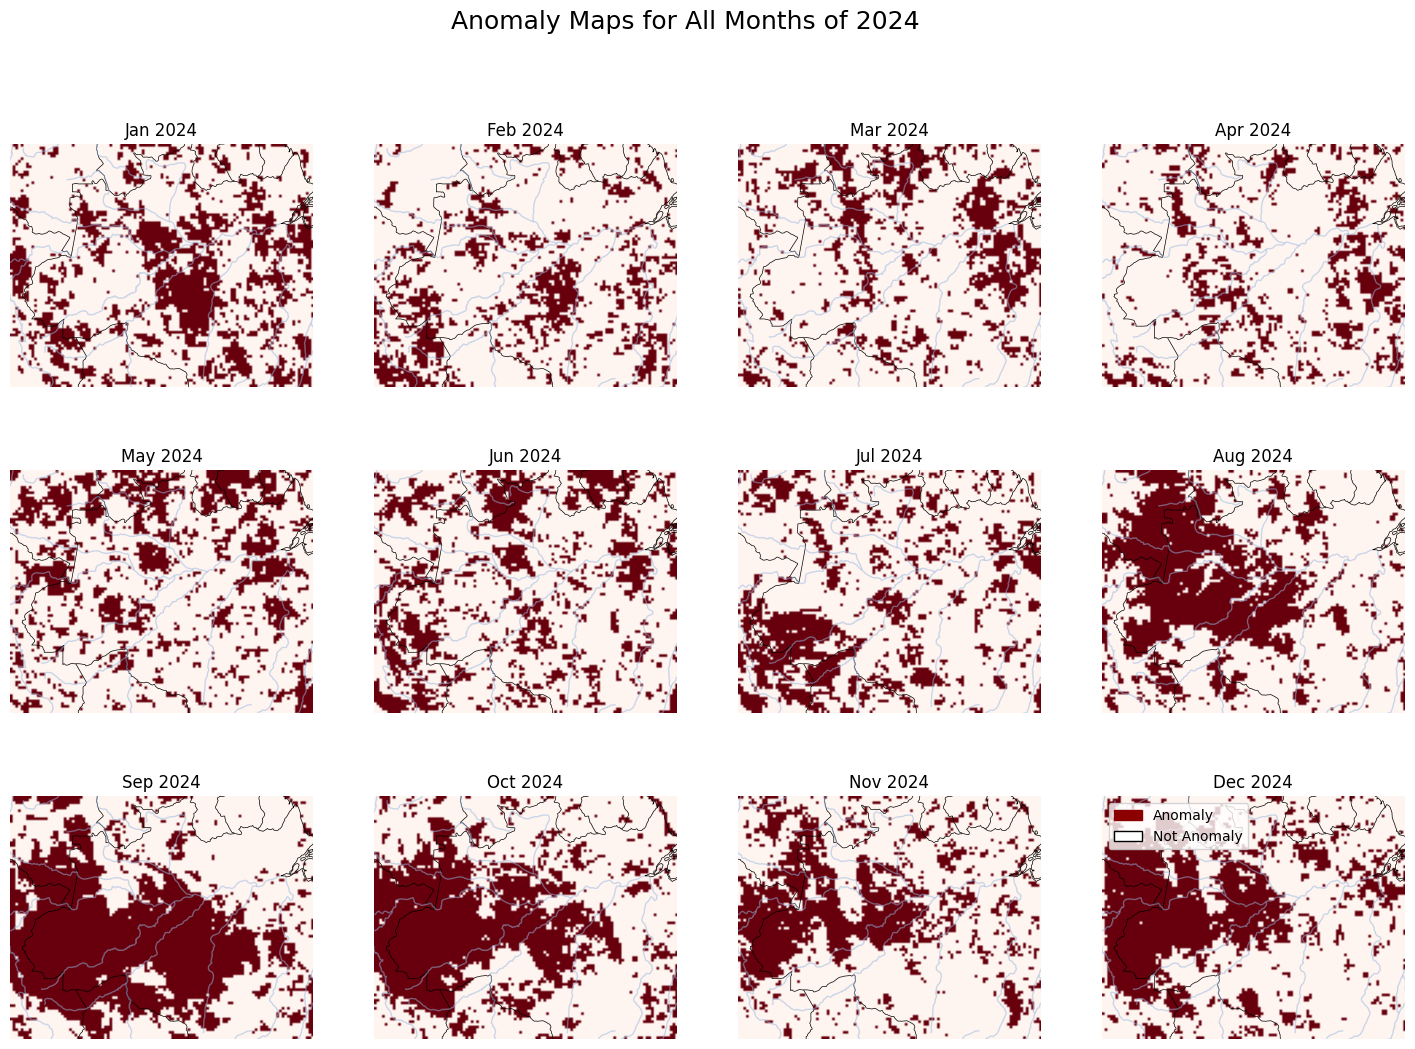

Anomaly Percentages Table for 2024:
   Month  Anomaly % (2024)
0    Jan             29.29
1    Feb             20.62
2    Mar             22.31
3    Apr             18.06
4    May             27.78
5    Jun             28.17
6    Jul             26.51
7    Aug             37.44
8    Sep             48.39
9    Oct             40.64
10   Nov             28.57
11   Dec             36.22


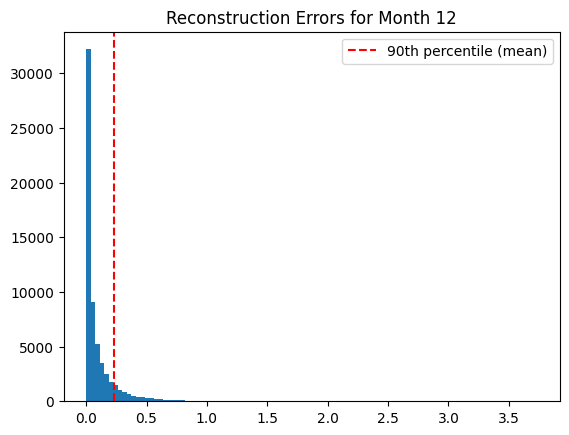

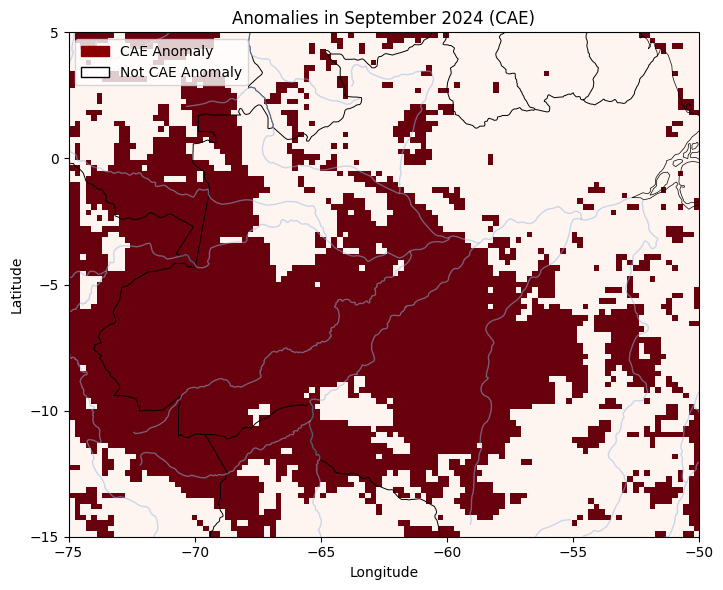

Mean Anomaly Percentages for Rolling 3-Month Seasons (2024):
  Rolling Season  Mean Anomaly % (2024)
0    Jan-Feb-Mar                  24.07
1    Feb-Mar-Apr                  20.33
2    Mar-Apr-May                  22.72
3    Apr-May-Jun                  24.67
4    May-Jun-Jul                  27.49
5    Jun-Jul-Aug                  30.71
6    Jul-Aug-Sep                  37.45
7    Aug-Sep-Oct                  42.16
8    Sep-Oct-Nov                  39.20
9    Oct-Nov-Dec                  35.14


In [613]:
from matplotlib.patches import Patch



reconstruction_error_pixel = (original - reconstructed) ** 2 
print("Reconstruction error shape:", reconstruction_error_pixel.shape)  
thresholds_per_month = np.percentile(reconstruction_error_pixel, 99, axis = 0) 
#print("Thresholds per month:", thresholds_per_month)  # shape: (12, 100, 100) 
anomalies_pixel = reconstruction_error_pixel > thresholds_per_month


anomaly_list = []

for year in range(anomalies_pixel.shape[0]):
    for month in range(12):
        lat_idx, lon_idx = np.where(anomalies_pixel[year, month])
        for i in range(len(lat_idx)):
            anomaly_list.append({
                'year': 2019 + year,  # adjust this based on your start year
                'month': month + 1,
                'lat_idx': lat_idx[i],
                'lon_idx': lon_idx[i],
                'error': reconstruction_error_pixel[year, month, lat_idx[i], lon_idx[i]]
            })

anomaly_df = pd.DataFrame(anomaly_list)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Anomaly Maps for All Months of 2024", fontsize=18)

for month_idx in range(12):
    ax = axs[month_idx // 4, month_idx % 4]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    anomaly_map = anomalies_pixel[5, month_idx]  # year_idx = 5 for 2024
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())
    ax.set_title(f"{months[month_idx]} 2024")
    ax.axis('off')

legend_elements = [
    Patch(facecolor='darkred', edgecolor='darkred', label='Anomaly'),
    Patch(facecolor='white', edgecolor='black', label='Not Anomaly')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True)
plt.show()

# Calculate anomaly percentages for each month in 2024 (year_idx = 5)
anomaly_percentages_2024 = []
for month in range(12):
    mask = anomalies_pixel[5, month]
    total = np.isfinite(mask).sum()
    anomalies = np.nansum(mask)
    percent = (anomalies / total) * 100 if total > 0 else np.nan
    anomaly_percentages_2024.append(percent)

# Create DataFrame for 2024
anomaly_percentages_2024_df = pd.DataFrame({
    'Month': months,
    'Anomaly % (2024)': np.round(anomaly_percentages_2024, 2)
})

print("Anomaly Percentages Table for 2024:")
print(anomaly_percentages_2024_df)

# Optionally, save to CSV
anomaly_percentages_2024_df.to_csv("amazonas_anomaly_percentages_2024.csv", index=False)

plt.hist(reconstruction_error_pixel[:, month_idx].flatten(), bins=100)
plt.axvline(thresholds_per_month[month_idx].mean(), color='r', linestyle='--', label='90th percentile (mean)')
plt.title(f"Reconstruction Errors for Month {month_idx + 1}")
plt.legend()
plt.show()

# Plot anomaly map for September (month_idx = 8) for 2024 using binary legend
month_idx = 8  # September (0-based index)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.7)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)

# Plot anomaly map for September 2024
anomaly_map_sept = anomalies_pixel[5, month_idx]
im = ax.imshow(anomaly_map_sept, cmap='Reds', origin='lower',
               extent=[lon_min, lon_max, lat_min, lat_max],
               transform=ccrs.PlateCarree(), vmin=0, vmax=1)

# Set ticks for coordinates
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.tick_params(labelsize=10)

ax.set_title("Anomalies in September 2024 (CAE)")
legend_elements = [
    Patch(facecolor='darkred', edgecolor='darkred', label='CAE Anomaly'),
    Patch(facecolor='white', edgecolor='black', label='Not CAE Anomaly')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# Calculate mean anomaly percentages for rolling 3-month seasons in 2024
rolling_labels = []
rolling_means = []

for start_month in range(10):  # 0 to 9 for 12 months, window size 3
    label = f"{months[start_month]}-{months[start_month+1]}-{months[start_month+2]}"
    mean_percent = np.mean(anomaly_percentages_2024[start_month:start_month+3])
    rolling_labels.append(label)
    rolling_means.append(round(mean_percent, 2))

rolling_season_df = pd.DataFrame({
    'Rolling Season': rolling_labels,
    'Mean Anomaly % (2024)': rolling_means
})

print("Mean Anomaly Percentages for Rolling 3-Month Seasons (2024):")
print(rolling_season_df)
# Calculate mean anomaly percentages for standard seasons in 2024: JFM, AMJ, JAS, OND
season_months = {
    'JFM': [0, 1, 2],   # Jan, Feb, Mar
    'AMJ': [3, 4, 5],   # Apr, May, Jun
    'JAS': [6, 7, 8],   # Jul, Aug, Sep
    'OND': [9, 10, 11]  # Oct, Nov, Dec
}


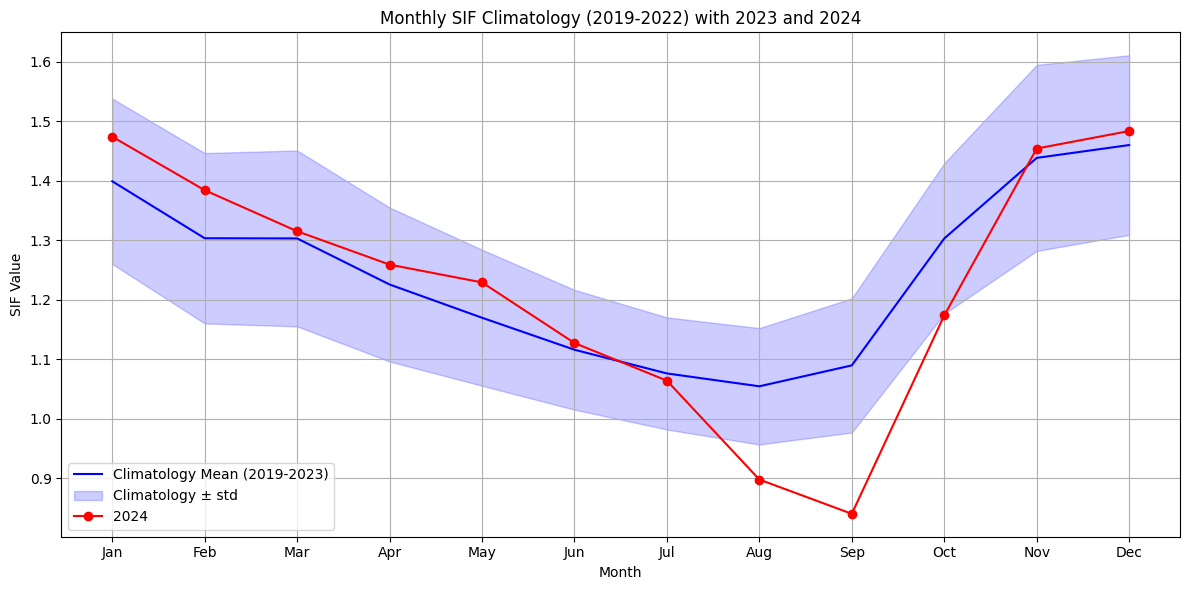

/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_13692/516489594.py:26: RuntimeWarning: divide by zero encountered in divide
  z_scores = (sif_monthly[4:] - climatology_mean) / climatology_std  # shape: (2, 12, lat, lon)
/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_13692/516489594.py:26: RuntimeWarning: invalid value encountered in divide
  z_scores = (sif_monthly[4:] - climatology_mean) / climatology_std  # shape: (2, 12, lat, lon)


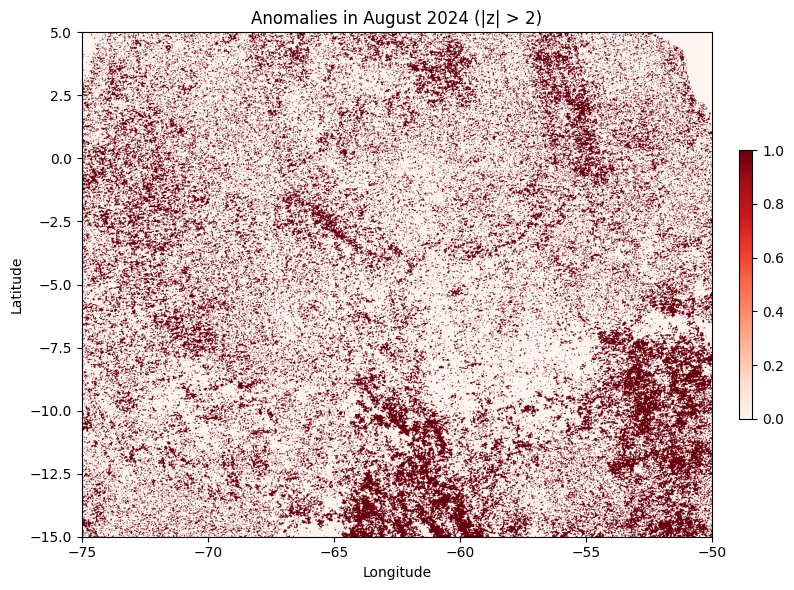

In [607]:
# 1. Compute mean and std for each pixel and month from the first 4 years (2019-2022)
climatology_mean = np.mean(sif_monthly[:4], axis=0)  # shape: (12, lat, lon)
climatology_std = np.std(sif_monthly[:4], axis=0)    # shape: (12, lat, lon)

# Plot climatology mean and std as shaded area, with 2023 and 2024 overlaid
clim_mean = np.nanmean(climatology_mean, axis=(1, 2))  # shape: (12,)
clim_std = np.nanmean(climatology_std, axis=(1, 2))    # shape: (12,)

months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
plt.plot(months_labels, clim_mean, label='Climatology Mean (2019-2023)', color='blue')
plt.fill_between(months_labels, clim_mean - clim_std, clim_mean + clim_std, color='blue', alpha=0.2, label='Climatology ± std')

plt.plot(months_labels, np.nanmean(sif_monthly[5], axis=(1, 2)), label='2024', color='red', marker='o')

plt.xlabel('Month')
plt.ylabel('SIF Value')
plt.title('Monthly SIF Climatology (2019-2022) with 2023 and 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Compute z-score for each pixel and month for 2023 and 2024 (years[4:] = [2023, 2024])
z_scores = (sif_monthly[4:] - climatology_mean) / climatology_std  # shape: (2, 12, lat, lon)

# 3. Flag anomalies where |z| > 2
anomaly_z = np.abs(z_scores) > 2  # shape: (2, 12, lat, lon)

# Plot anomaly maps for August (month_idx = 7) for 2023 and 2024
month_idx = 8
year_to_plot = 0


anomaly_map = anomaly_z[year_to_plot, month_idx]  # shape: (lat, lon)
plt.figure(figsize=(8, 6))
im = plt.imshow(anomaly_map, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max])
plt.title("Anomalies in August 2024 (|z| > 2)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im, orientation='vertical', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()



In [614]:
# Calculate anomaly mask for 2023 and 2024 using z_scores (already computed)
# anomaly_mask shape: (2, 12, lat, lon), years[4:] = [2023, 2024]
print("Anomaly mask shape:", anomaly_z.shape)
anomaly_percentages_z = []

for year_offset, year in enumerate(years[4:]):  # 2023, 2024
    year_percentages = []
    for month_idx in range(12):
        mask = anomaly_z[year_offset, month_idx]
        total = np.isfinite(mask).sum()  # Exclude NaNs
        anomalies = np.nansum(mask)
        percent = (anomalies / total) * 100 if total > 0 else np.nan
        year_percentages.append(percent)
    anomaly_percentages_z.append(year_percentages)

# Create DataFrame
months_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
anomaly_z_df = pd.DataFrame(np.array(anomaly_percentages_z[1]).T, columns=[2024], index=months_short)

print("Percentage of anomalies in 2023 and 2024 (z-score method):")
print(anomaly_z_df.round(3))

# Optionally, save to CSV
anomaly_z_df.to_csv("anomaly_percentages_zscore_2023_2024.csv")



# Calculate rolling 3-month median anomaly percentages for 2024 (z-score method), starting with DJF (Dec 2023, Jan 2024, Feb 2024)
season_labels = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
medians_3month = []

# Get December 2023 anomaly percentage
dec_2023_percent = anomaly_percentages_z[0][11]  # 2023, December (month_idx=11)
# Get 2024 anomaly percentages
monthly_percentages_2024 = np.array(anomaly_percentages_z[1])  # 2024

# DJF: Dec 2023, Jan 2024, Feb 2024
djf = np.nanmedian([dec_2023_percent, monthly_percentages_2024[0], monthly_percentages_2024[1]])
medians_3month.append(djf)

# Rolling 3-month medians for 2024: JFM, FMA, ..., OND
for i in range(0, 10):
    median_val = np.nanmean(monthly_percentages_2024[i:i+3])
    medians_3month.append(median_val)

anomaly_z_3month_df = pd.DataFrame({
    'Season': season_labels,
    'Median Anomaly % (2024)': np.round(medians_3month, 2)
})

print("3-Month Median Anomaly Percentages Table for 2024 (z-score method, DJF starts with Dec 2023):")
print(anomaly_z_3month_df)

# Optionally, save to CSV
anomaly_z_3month_df.to_csv("anomaly_percentages_zscore_2024_3month_median_DJF.csv", index=False)
# # Calculate rolling 3-month median anomaly percentages for 2024 (z-score method)
# window = 3
# season_labels = ['JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
# medians_3month = []

# # Only for 2024 (anomaly_percentages_z[1])
# monthly_percentages_2024 = np.array(anomaly_percentages_z[0])

# for i in range(10):  # 12 months - 3 + 1 = 10 seasons
#     median_val = np.nanmedian(monthly_percentages_2024[i:i+window])
#     medians_3month.append(median_val)

# anomaly_z_3month_df = pd.DataFrame({
#     'Season': season_labels,
#     'Median Anomaly % (2024)': np.round(medians_3month, 2)
# })

# print("3-Month Median Anomaly Percentages Table for 2024 (z-score method):")
# print(anomaly_z_3month_df)

# # Optionally, save to CSV
# anomaly_z_3month_df.to_csv("anomaly_percentages_zscore_2024_3month_median.csv", index=False)

Anomaly mask shape: (2, 12, 911, 1137)
Percentage of anomalies in 2023 and 2024 (z-score method):
       2024
Jan  36.433
Feb  30.087
Mar  30.172
Apr  27.158
May  28.033
Jun  25.515
Jul  24.188
Aug  43.917
Sep  55.394
Oct  30.611
Nov  28.444
Dec  27.669
3-Month Median Anomaly Percentages Table for 2024 (z-score method, DJF starts with Dec 2023):
   Season  Median Anomaly % (2024)
0     DJF                    31.55
1     JFM                    32.23
2     FMA                    29.14
3     MAM                    28.45
4     AMJ                    26.90
5     MJJ                    25.91
6     JJA                    31.21
7     JAS                    41.17
8     ASO                    43.31
9     SON                    38.15
10    OND                    28.91


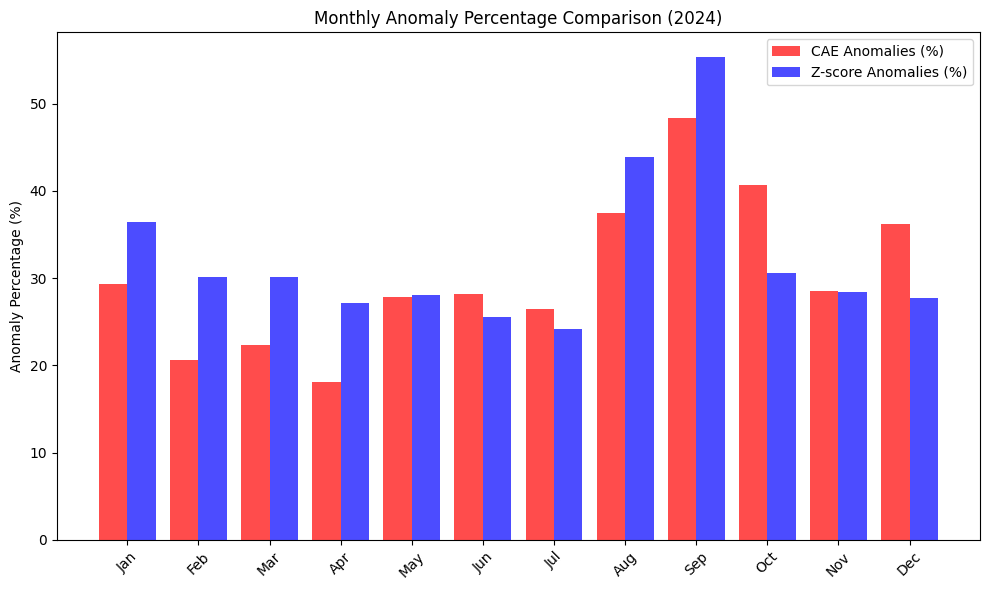

In [616]:
# Compute mean anomaly percentage for each month in 2024 using both methods

# Z-score method (already computed in anomaly_percentages_z)
mean_anomaly_zscore_2024 = np.array(anomaly_percentages_z[1])  # shape: (12,)

# Convolutional autoencoder method (from anomaly_percentages_2024)
mean_anomaly_cae_2024 = np.array(anomaly_percentages_2024)  # shape: (12,)

plt.figure(figsize=(10, 6))
bar_width = 0.4
x = np.arange(len(months))

plt.bar(x - bar_width/2, mean_anomaly_cae_2024, width=bar_width, label='CAE Anomalies (%)', color='red', alpha=0.7)
plt.bar(x + bar_width/2, mean_anomaly_zscore_2024, width=bar_width, label='Z-score Anomalies (%)', color='blue', alpha=0.7)

plt.xticks(x, months, rotation=45)
plt.ylabel('Anomaly Percentage (%)')
plt.title('Monthly Anomaly Percentage Comparison (2024)')
plt.legend()
plt.tight_layout()
plt.show()

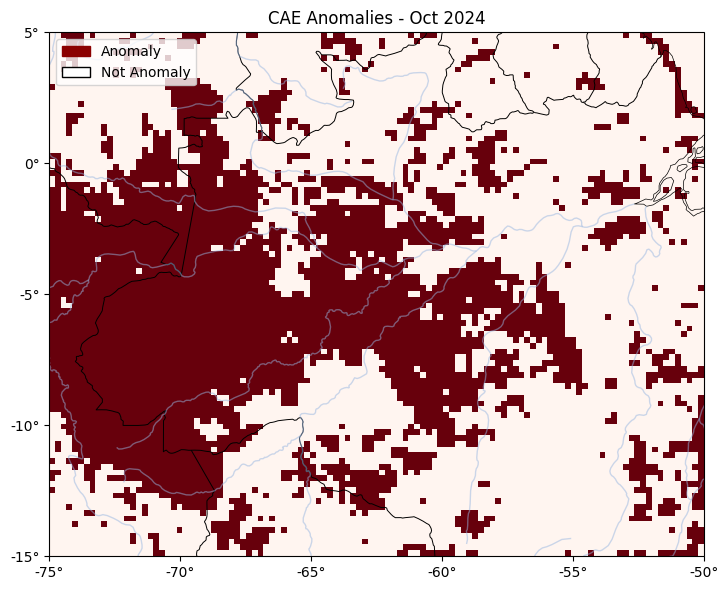

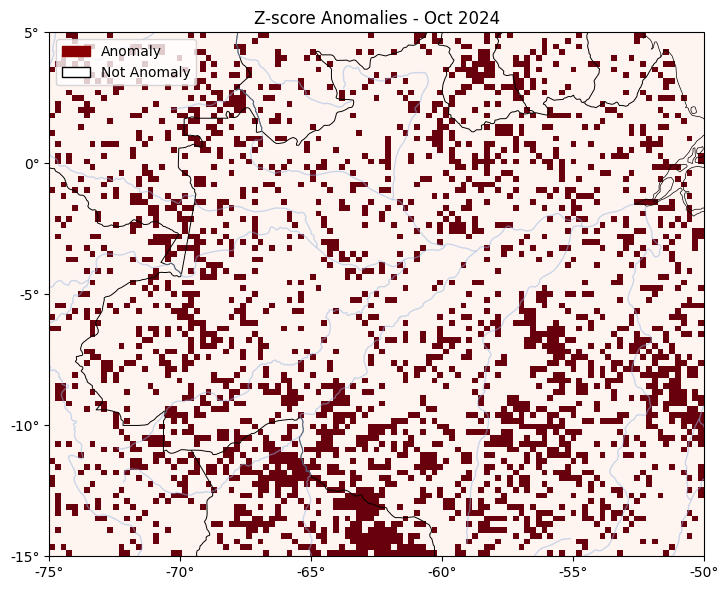

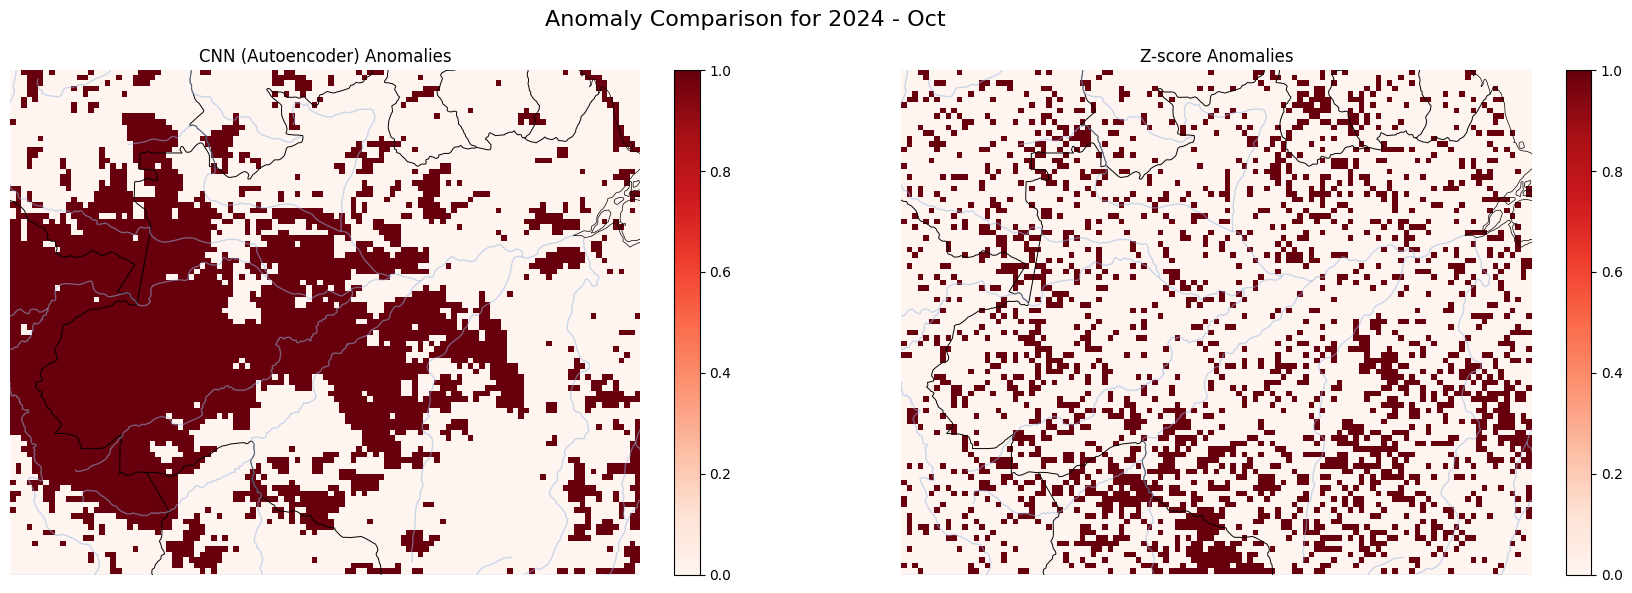

In [602]:

# 1. CNN-based anomalies for 2024 (year_idx=5)
cnn_anomalies_2024 = anomalies_pixel[5]  # shape: (12, 68, 100) or (12, 100, 100) depending on your resizing

# 2. Z-score-based anomalies for 2024 (year_offset=1)
zscore_anomalies_2024 = anomaly_z[0]  # shape: (12, lat, lon)

# For visualization, select a month (e.g., August, index 7)
month_idx = 9

# Resize zscore_anomalies_2024 to (12, 68, 100) using nearest-neighbor interpolation
zscore_anomalies_2024_resized = np.empty((12, 91, 113), dtype=bool)
for m in range(12):
    zscore_anomalies_2024_resized[m] = resize(
        zscore_anomalies_2024[m].astype(float),
        (91, 113),
        order=0,  # nearest-neighbor
        preserve_range=True,
        anti_aliasing=False
    ).astype(bool)


# Plot 1: CNN-based anomaly map for the selected month
fig1 = plt.figure(figsize=(8, 6))
proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]
ax1 = plt.axes(projection=proj)
ax1.set_extent(extent, crs=proj)
ax1.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax1.add_feature(cfeature.BORDERS, linewidth=0.7)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.RIVERS, alpha=0.5)
im1 = ax1.imshow(cnn_anomalies_2024[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj, vmin=0, vmax=1)
ax1.set_title(f"CAE Anomalies - {months[month_idx]} 2024")
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xticklabels([f"{lon:.0f}°" for lon in xticks])
ax1.set_yticklabels([f"{lat:.0f}°" for lat in yticks])
legend_elements = [
        Patch(facecolor='darkred', edgecolor='darkred', label='Anomaly'),
        Patch(facecolor='white', edgecolor='black', label='Not Anomaly')
                ]
ax1.legend(handles=legend_elements, loc='upper left', frameon=True)
#plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
# Add latitude and longitude ticks and labels to the axis

plt.tight_layout()
plt.show()

    # Plot 2: Z-score-based anomaly map for the selected month
fig2 = plt.figure(figsize=(8, 6))
ax2 = plt.axes(projection=proj)
ax2.set_extent(extent, crs=proj)
ax2.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax2.add_feature(cfeature.BORDERS, linewidth=0.7)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.RIVERS, alpha=0.5)
im2 = ax2.imshow(zscore_anomalies_2024_resized[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj, vmin=0, vmax=1)
ax2.set_title(f"Z-score Anomalies - {months[month_idx]} 2024")
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.set_xticklabels([f"{lon:.0f}°" for lon in xticks])
ax2.set_yticklabels([f"{lat:.0f}°" for lat in yticks])
ax2.legend(handles=legend_elements, loc='upper left', frameon=True)
#plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(18, 6))

fig.suptitle(f"Anomaly Comparison for 2024 - {months[month_idx]}", fontsize=16)

# Define projection and extent for Amazonas
proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]

# CNN-based anomaly map
ax0 = plt.subplot(1, 2, 1, projection=proj)
ax0.set_extent(extent, crs=proj)
ax0.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax0.add_feature(cfeature.BORDERS, linewidth=0.7)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax0.add_feature(cfeature.RIVERS, alpha=0.5)
im0 = ax0.imshow(cnn_anomalies_2024[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj)
ax0.set_title("CNN (Autoencoder) Anomalies")
ax0.axis('off')

# Z-score-based anomaly map
ax1 = plt.subplot(1, 2, 2, projection=proj)
ax1.set_extent(extent, crs=proj)
ax1.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax1.add_feature(cfeature.BORDERS, linewidth=0.7)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.RIVERS, alpha=0.5)
im1 = ax1.imshow(zscore_anomalies_2024_resized[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj)
ax1.set_title("Z-score Anomalies")
ax1.axis('off')

# # Difference map
# diff_map = zscore_anomalies_2024_resized[month_idx].astype(int) - cnn_anomalies_2024[month_idx].astype(int)
# ax2 = plt.subplot(1, 3, 3, projection=proj)
# ax2.set_extent(extent, crs=proj)
# ax2.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
# ax2.add_feature(cfeature.BORDERS, linewidth=0.7)
# ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax2.add_feature(cfeature.RIVERS, alpha=0.5)
# im2 = ax2.imshow(diff_map, cmap='bwr', origin='lower', extent=extent, vmin=-1, vmax=1, transform=proj)
# ax2.set_title("Difference (CNN - Z-score)")
# ax2.axis('off')

fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
# fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



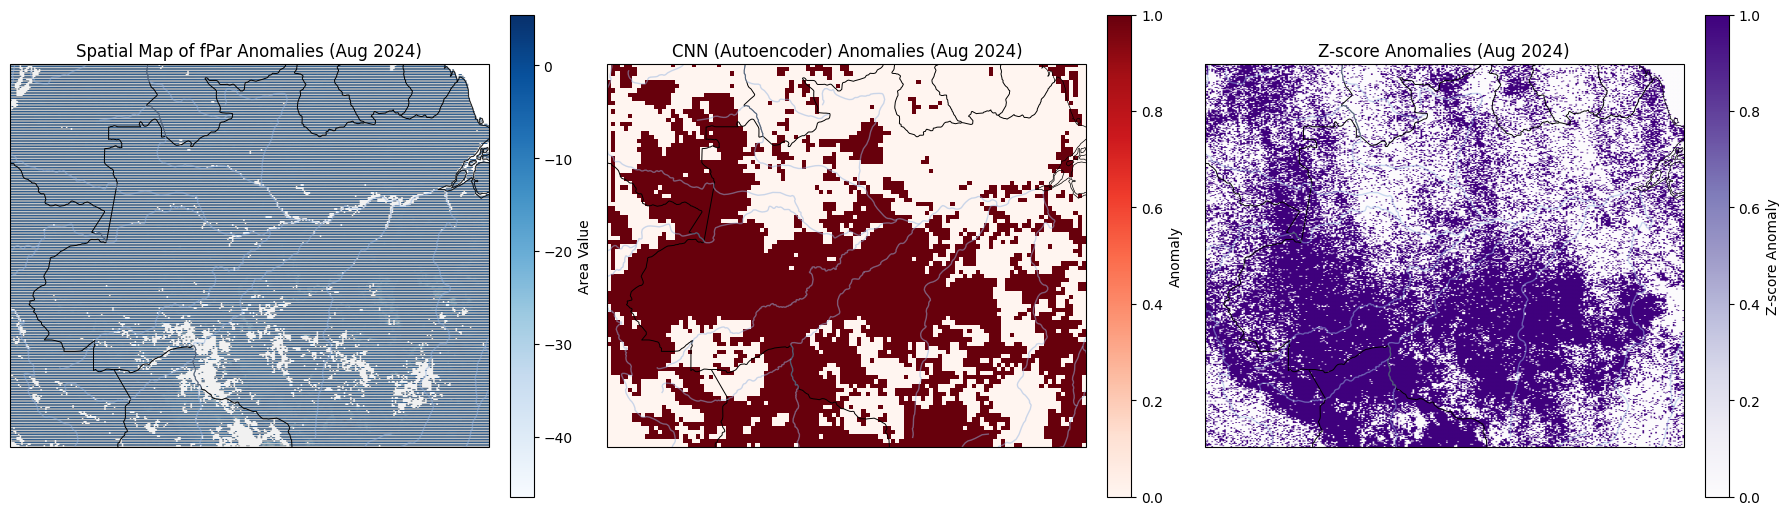

In [ ]:
# Plot spatial map of area_2024_monthly for August (month 8, index 7)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
month_idx = 10

# 1. fPar anomalies map (August)
axs[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
axs[0].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.7)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.RIVERS, alpha=0.5)
im0 = axs[0].imshow(area_2024_monthly[month_idx], cmap='Blues', origin='lower',
                    extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())
axs[0].set_title("Spatial Map of fPar Anomalies (Aug 2024)")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
plt.colorbar(im0, ax=axs[0], orientation='vertical', fraction=0.046, pad=0.04, label='Area Value')

# 2. CNN-based anomalies for 2024 (August) # shape: (12, 75, 94) or (12, 100, 100)
axs[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
axs[1].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.7)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.RIVERS, alpha=0.5)
im1 = axs[1].imshow(cnn_anomalies_2024[month_idx], cmap='Reds', origin='lower',
                    extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())
axs[1].set_title("CNN (Autoencoder) Anomalies (Aug 2024)")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")
plt.colorbar(im1, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04, label='Anomaly')

# 3. Z-score-based anomalies for 2024 (August)
zscore_anomalies_2024_resized = np.empty((12, area_2024_monthly.shape[1], area_2024_monthly.shape[2]), dtype=bool)
for m in range(12):
    zscore_anomalies_2024_resized[m] = resize(
        zscore_anomalies_2024[m].astype(float),
        (area_2024_monthly.shape[1], area_2024_monthly.shape[2]),
        order=0,  # nearest-neighbor
        preserve_range=True,
        anti_aliasing=False
    ).astype(bool)
axs[2].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
axs[2].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
axs[2].add_feature(cfeature.BORDERS, linewidth=0.7)
axs[2].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[2].add_feature(cfeature.RIVERS, alpha=0.5)
im2 = axs[2].imshow(zscore_anomalies_2024_resized[month_idx], cmap='Purples', origin='lower',
                    extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())
axs[2].set_title("Z-score Anomalies (Aug 2024)")
axs[2].set_xlabel("Longitude")
axs[2].set_ylabel("Latitude")
plt.colorbar(im2, ax=axs[2], orientation='vertical', fraction=0.046, pad=0.04, label='Z-score Anomaly')

plt.tight_layout()
plt.show()
